# Image Classification with Pre-trained Imagenet CNN

This example is adapted from [Caffe's iPython Notebook example](http://nbviewer.ipython.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb). We use pre-trained CNN model [converted](http://mochajl.readthedocs.org/en/latest/user-guide/tools/import-caffe-model.html) from Caffe's [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). Specifically, we use `bvlc_reference_caffenet`, which is the same model used in Caffe's own iPython Notebook example.

This notebook is located in `examples/ijulia/ilsvrc12` under Mocha's source directory. If you want to run this example by yourself, you need to

* Install [IJulia.jl](https://github.com/JuliaLang/IJulia.jl), which is a Julia backend for IPython. Of course, you also need to have Python and IPython installed.
* Install [Images.jl](https://github.com/timholy/Images.jl), which we will use to read image files in this example.
* (Optional) Install [Gadfly.jl](http://gadflyjl.org/), which will be used to plot the class probability prediction.
* Download pre-trained CNN model. There is a shell script `get-model.sh` that you could run to download the pre-trained CNN model in HDF5 format converted from Caffe's original binary protocol buffer format.

After all the preparation, you can start the notebook by executing the following command in this demo's source directory.

```bash
ipython notebook --profile julia
```

## Constructing Convolutional Network

We will use Mocha's native extension here to get faster convolution. If you prefer to disable it or use CUDA backend instead, please refer to [Mocha's document](http://mochajl.readthedocs.org/en/latest/user-guide/backend.html) for details.

In [1]:
ENV["MOCHA_USE_NATIVE_EXT"] = "true"

using Mocha

backend = CPUBackend()
init(backend)

  likely near /Users/chiyuan/.julia/v0.4/Logging/src/Logging.jl:24
  likely near /Users/chiyuan/.julia/v0.4/Logging/src/Logging.jl:24
  likely near /Users/chiyuan/.julia/v0.4/Logging/src/Logging.jl:24
  likely near /Users/chiyuan/.julia/v0.4/Logging/src/Logging.jl:40
  likely near /Users/chiyuan/.julia/v0.4/Logging/src/Logging.jl:40
  likely near /Users/chiyuan/.julia/v0.4/Logging/src/Logging.jl:40


Configuring Mocha...
 * CUDA       disabled by default
 * Native Ext enabled (MOCHA_USE_NATIVE_EXT environment variable detected)
Mocha configured, continue loading module...
Loading native extension libmochaext.so...
Native extension loaded
DefaultBackend = Mocha.CPUBackend

Next we will define the network structure. This is directly adapted from Caffe's `bvlc_reference_caffenet` model definition. Please refer to Mocha's CIFAR-10 tutorial on how to translate Caffe's model definition to Mocha. This model takes 3-channel color images of size 256-by-256 and crop to take a 227-by-227 region. 

In [2]:
img_width, img_height, img_channels = (256, 256, 3)
crop_size = (227, 227)
batch_size = 1  # could be larger if you want to classify a bunch of images at a time

layers = [
  MemoryDataLayer(name="data", tops=[:data], batch_size=batch_size,
      transformers=[(:data, DataTransformers.Scale(scale=255)),
                    (:data, DataTransformers.SubMean(mean_file="model/ilsvrc_2012_mean.hdf5"))],
      data = Array[zeros(img_width, img_height, img_channels, batch_size)])
  CropLayer(name="crop", tops=[:cropped], bottoms=[:data], crop_size=crop_size)
  ConvolutionLayer(name="conv1", tops=[:conv1], bottoms=[:cropped],
      kernel=(11,11), stride=(4,4), n_filter=96, neuron=Neurons.ReLU())
  PoolingLayer(name="pool1", tops=[:pool1], bottoms=[:conv1],
      kernel=(3,3), stride=(2,2), pooling=Pooling.Max())
  LRNLayer(name="norm1", tops=[:norm1], bottoms=[:pool1],
      kernel=5, scale=0.0001, power=0.75)
  ConvolutionLayer(name="conv2", tops=[:conv2], bottoms=[:norm1],
      kernel=(5,5), pad=(2,2), n_filter=256, n_group=2, neuron=Neurons.ReLU())
  PoolingLayer(name="pool2", tops=[:pool2], bottoms=[:conv2],
      kernel=(3,3), stride=(2,2), pooling=Pooling.Max())
  LRNLayer(name="norm2", tops=[:norm2], bottoms=[:pool2],
      kernel=5, scale=0.0001, power=0.75)
  ConvolutionLayer(name="conv3", tops=[:conv3], bottoms=[:norm2],
      kernel=(3,3), pad=(1,1), n_filter=384, neuron=Neurons.ReLU())
  ConvolutionLayer(name="conv4", tops=[:conv4], bottoms=[:conv3],
      kernel=(3,3), pad=(1,1), n_filter=384, n_group=2, neuron=Neurons.ReLU())
  ConvolutionLayer(name="conv5", tops=[:conv5], bottoms=[:conv4],
      kernel=(3,3), pad=(1,1), n_filter=256, n_group=2, neuron=Neurons.ReLU())
  PoolingLayer(name="pool5", tops=[:pool5], bottoms=[:conv5],
      kernel=(3,3), stride=(2,2), pooling=Pooling.Max())
  InnerProductLayer(name="fc6", tops=[:fc6], bottoms=[:pool5],
      output_dim=4096, neuron=Neurons.ReLU())
  InnerProductLayer(name="fc7", tops=[:fc7], bottoms=[:fc6],
      output_dim=4096, neuron=Neurons.ReLU())
  InnerProductLayer(name="fc8", tops=[:fc8], bottoms=[:fc7],
      output_dim=1000)
  SoftmaxLayer(name="prob", tops=[:prob], bottoms=[:fc8])
]

net = Net("imagenet", backend, layers)
println(net)


14-Oct 16:12:43:INFO:root:Constructing net imagenet on Mocha.CPUBackend...
14-Oct 16:12:43:INFO:root:Topological sorting 16 layers...
14-Oct 16:12:43:INFO:root:Setup layers...
14-Oct 16:12:45:INFO:root:Network constructed!
************************************************************
          NAME: imagenet
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 16 layers
............................................................
 *** Mocha.MemoryDataLayer(data)
    Outputs ---------------------------
          data: Blob(256 x 256 x 3 x 1)
............................................................
 *** Mocha.CropLayer(crop)
    Inputs ----------------------------
          data: Blob(256 x 256 x 3 x 1)
    Outputs ---------------------------
       cropped: Blob(227 x 227 x 3 x 1)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
       cropped: Blob(227 x 227 x 3 x 1)
    Outputs ---------------------

In [5]:
open("net.dot", "w") do out net2dot(out, net) end
run(pipeline(`dot -Tpng net.dot`, "net.png"))

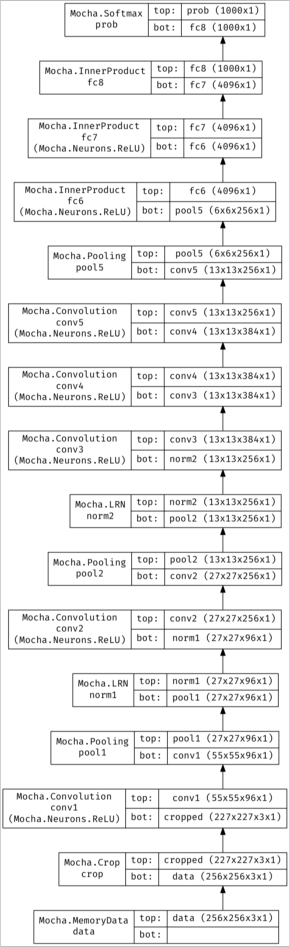

In [6]:
using Images
imread("net.png")

In [7]:
# load pre-trained network parameters

using HDF5
h5open("model/bvlc_reference_caffenet.hdf5", "r") do h5
  load_network(h5, net)
end
init(net)

14-Oct 16:13:30:DEBUG:root:Loading parameters from HDF5 for layer conv1
14-Oct 16:13:30:WARNING:root:Automatic converting saved filter from Float32 to Float64
14-Oct 16:13:30:WARNING:root:Automatic converting saved bias from Float32 to Float64
14-Oct 16:13:30:DEBUG:root:Loading parameters from HDF5 for layer conv2
14-Oct 16:13:30:WARNING:root:Automatic converting saved filter from Float32 to Float64
14-Oct 16:13:30:WARNING:root:Automatic converting saved bias from Float32 to Float64
14-Oct 16:13:30:DEBUG:root:Loading parameters from HDF5 for layer conv3
14-Oct 16:13:30:WARNING:root:Automatic converting saved filter from Float32 to Float64
14-Oct 16:13:30:WARNING:root:Automatic converting saved bias from Float32 to Float64
14-Oct 16:13:30:DEBUG:root:Loading parameters from HDF5 for layer conv4
14-Oct 16:13:30:WARNING:root:Automatic converting saved filter from Float32 to Float64
14-Oct 16:13:30:WARNING:root:Automatic converting saved bias from Float32 to Float64
14-Oct 16:13:30:DEBUG:ro

## Classifying Images

After loading the network parameters, we can now feed images to the network and read the output from the top softmax layer to get predictions. We provided a demo wrapper of the network as a simple image classifier interface in `tools/image-classifier.jl`. We will be using that wrapper in this demo.

Before constructing the classifier, we load the class names get a better understanding the numerical predictions. The original network was trained on a 1000-class dataset. The classes used by Caffe's pre-trained model could be found in `synset_words.txt`.

In [8]:
classes = open("synset_words.txt") do s map(x -> replace(strip(x), r"^n[0-9]+ ", ""), readlines(s)) end

1000-element Array{ASCIIString,1}:
 "tench, Tinca tinca"                                                                 
 "goldfish, Carassius auratus"                                                        
 "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias"
 "tiger shark, Galeocerdo cuvieri"                                                    
 "hammerhead, hammerhead shark"                                                       
 "electric ray, crampfish, numbfish, torpedo"                                         
 "stingray"                                                                           
 "cock"                                                                               
 "hen"                                                                                
 "ostrich, Struthio camelus"                                                          
 "brambling, Fringilla montifringilla"                                                
 "goldfi

Caffe's CNN on imagenet is trained with BGR channel order, so we specify channel re-ordering from the standard RGB order. The image data from Images.jl is in the range [0,1]. According to Caffe's original tutorial, we also need to re-scale the image data from [0,1] to [0,255], and subtract the mean. But those are already handled in the network definition via data transformers attached to the data layer.

The second parameter to the constructor of `ImageClassifier` is the name of the blob in the network that gives the final prediction. Here we are using the output of the softmax layer.

In [9]:
require(joinpath(Pkg.dir("Mocha"), "tools/image-classifier.jl"))
classifier = ImageClassifier(net, :prob, channel_order=(3,2,1), classes=classes)
println("Classifier constructed")

Classifier constructed


 in depwarn at deprecated.jl:73
 [inlined code] from deprecated.jl:694
 in require at no file:0
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/chiyuan/.julia/v0.3/IJulia/src/execute_request.jl:177
 in eventloop at /Users/chiyuan/.julia/v0.3/IJulia/src/IJulia.jl:144
 in anonymous at task.jl:447
while loading In[9], in expression starting on line 1


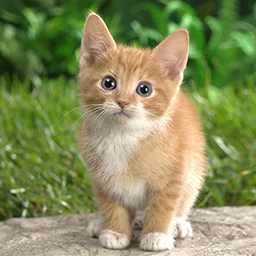

In [10]:
# load image for prediction
img = imread("images/cat256.jpg")

In [11]:
# get prediction
prob, class = classify(classifier, img)
println(class)

tabby, tabby cat


As we can see, the predicted class is tabby, tabby cat. We can also plot the top 5 highest predicted probability. If you didn't install Gadfly.jl, this step could be omitted. Currently (before Julia's static compilation is implemented) it takes a very long time to load Gadfly.jl.

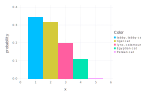

In [13]:
using Gadfly

n_plot = 5
n_best = sortperm(vec(prob), rev=true)[1:n_plot]
best_probs = prob[n_best]
best_labels = classes[n_best]

plot(x=1:length(best_probs), y=best_probs, color=best_labels, Geom.bar, Guide.ylabel("probability"))

As we can see, the predicted class probability is highly concentrated. Here is another example.

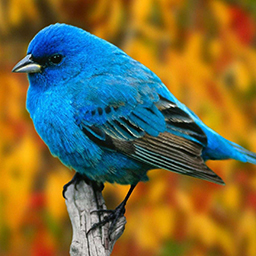

In [14]:
img2 = imread("images/bird.jpg")

In [15]:
prob, class = classify(classifier, img2)
println(class)

indigo bunting, indigo finch, indigo bird, Passerina cyanea
